# Imports

In [2]:
# General modules
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from os.path import sep
from tqdm import tqdm
from scipy.stats import binom
from matplotlib.patches import Rectangle

# Local modules
import binomial_confidence

# Enable re-load of local modules every time they are called
%load_ext autoreload
%autoreload 2
%aimport numpy 
%aimport pandas

# Find number of samples required to detect certain discrepancy

Note: this only applies to discrete variables where there are two possible outcomes for each entry: matching or not matching, between subordinate and supervisor. 

## Model discrepancy score as a binomial random variable

We will model discrepancy of a discrete variable as a binomial random variable with n samples and probability of success = d (here, success means non-matching values between subordinate and supervisor). That is, the "true discrepancy score" is d. 

Then the observed discrepancy score is a random variable drawn from the distribution binomial(n, d). Let us see what this distribution looks like:

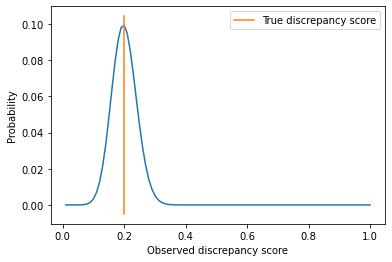

In [3]:
n = 100 # Number of samples
d = 0.2 # 'True' discrepancy score of this worker: 20% of samples are mismatching with supervisor.
x = np.linspace(1, n, 100) 

plt.figure()
plt.plot(x/n, binom.pmf(x, n, d))
plt.xlabel('Observed discrepancy score')
plt.ylabel('Probability')
plt.plot([d, d], plt.ylim(), label = 'True discrepancy score')
plt.legend()

If we increase the number of samples, the distribution of observed discrepancy scores will be 'tighter' around the true discrepancy score. 

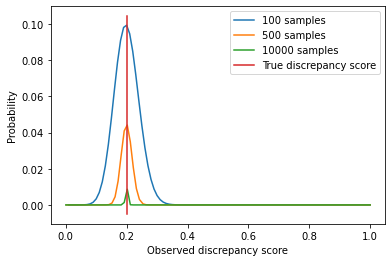

In [3]:
d = 0.2 # 'True' discrepancy score of this worker: 20% of samples are mismatching with supervisor.

plt.figure()

for n in (100, 500, 10000):
    
    x = np.linspace(1, n, 100).astype(int)
    prob = binom.pmf(x, n, d)
    plt.plot(x/n, prob, label = '{0} samples'.format(n))
    
plt.xlabel('Observed discrepancy score')
plt.ylabel('Probability')
plt.plot([d, d], plt.ylim(), label = 'True discrepancy score')
plt.legend()

## Classify discrepancy scores as good (green band)

We will now define a threshold of discrepancy score, below which workers will be classified as 'green band'. 

In [4]:
t1 = 0.3 # Threshold for green band (workers with discrepancy score < 0.3 are in green band)

The cdf of the binomial distribution gives the probability of classifying our worker above, with true discrepancy d = 0.2, as a green band worker. 

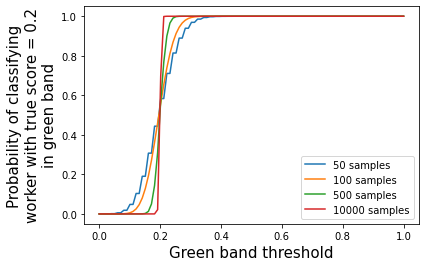

In [118]:
d = 0.2
t = np.linspace(0, 1, 100)
plt.figure()

for n in (50, 100, 500, 10000):

    prob = binom.cdf(t*n, n, d)
    plt.plot(t, prob, label = '{0} samples'.format(n))
    
plt.xlabel('Green band threshold', fontsize = 15)
plt.ylabel('Probability of classifying\nworker with true score = {0}\nin green band'.format(d), fontsize = 15)
plt.legend()


Let us zoom in around the threshold t1 = 0.3

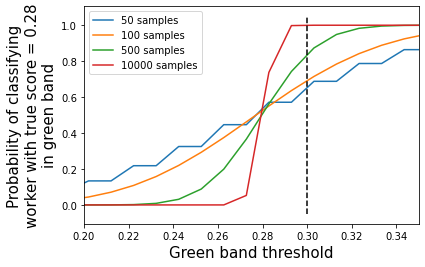

In [122]:
t = np.linspace(0, 1, 100)
plt.figure()
d = 0.28
for n in (50, 100, 500, 10000):

    prob = binom.cdf(t*n, n, d)
    plt.plot(t, prob, label = '{0} samples'.format(n))
    
plt.xlim((0.2, 0.35))
plt.plot((t1, t1), plt.ylim(), color = 'k', linestyle = '--')
plt.xlabel('Green band threshold', fontsize = 15)
plt.ylabel('Probability of classifying\nworker with true score = {0}\nin green band'.format(d), fontsize = 15)
plt.legend()


We can see that the probability of classifying this worker as green increases with the sample size, which makes sense, because more samples means our estimate of the discrepancy score will be closer to the true discrepancy score. In particular, the probabilities are:

In [7]:
for n in (50, 100, 500, 10000):

    print('{0} samples: probability = {1}'.format(n, binom.cdf(int(t1*n), n, d)))

50 samples: probability = 0.6878985972817714
100 samples: probability = 0.7149122007480799
500 samples: probability = 0.8520470694882497
10000 samples: probability = 0.9999954133880968


## Find number of samples required to classify scores with high confidence

Let's say we want to figure out the appropriate number of samples to get good classification. Let us define an 'accuracy' a = 0.02, and say that if the true discrepancy score is less than t1 - a, we would like to classify this worker as green band with high probability. Let that probability be 90%, or 0.9. 

Then, we can find the minimum number of samples for which true discrepancy score of 0.28 (or lower) will be classified as green band with probability 0.9.

To do this, we will guess two initial values of n: one very high, and one very low, and calculate the probability of classification using these values. Then we will do a binary search. We will calculate the probability for the mid-point of the two initial guesses. If it is < 0.9, we will assign the mid-point to the lower value, and if the probability is > 0.9, we will assign the mid-point to the higher value. We will repeat this until we get close enough to the desired probability 0.9.

In [123]:
a = 0.02 # Desired accuracy

tolerance = 0.001 # Looking for probability between 0.899 and 0.901 (binary search will be stopped if we get probability within this interval)

n_high = 5000 # Initial high guess for n
n_low = 2 # Initial low guess for n 

p_high = binom.cdf(int(t1*n_high), n_high, t1 - a) # Probability of classifying score t1 - a as green, with n_high samples
p_low = binom.cdf(int(t1*n_low), n_low, t1 - a) # Probability of classigying score t1 - a as green, with n_low samples
p = 0.9 # Desired probability of correct classification

assert(p < p_high) # If this is not true, we need to increase n_high 
assert(p > p_low) # If this is not true, we need to decrease n_low 

while np.logical_and(np.abs(p_high - p) > tolerance, n_low < n_high - 1):

    n_mid = int((n_high + n_low)/2)
    p_mid = binom.cdf(int(t1*n_mid), n_mid, t1 - a)
    if(p_mid > p):
        n_high = n_mid
    else:
        n_low = n_mid

    p_high = binom.cdf(int(t1*n_high), n_high, t1 - a)
    p_low = binom.cdf(int(t1*n_low), n_low, t1 - a)
    
    
print('To correctly classify workers with discrepancy score < {0} {1}% of the time, {2} samples are required.'.format(t1 - a, int(p*100), n_high))


To correctly classify workers with discrepancy score < 0.27999999999999997 90% of the time, 820 samples are required.


## Classify discrepancy scores as bad (red band)

Separately, we will have a threshold above which workers will be classified as 'red band'.

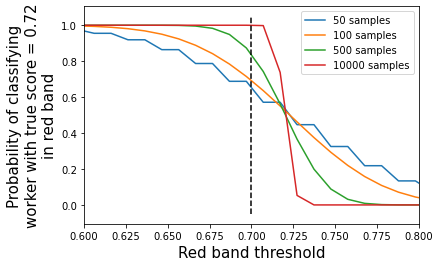

In [12]:
t2 = 0.7 # Threshold for red band (workers with discrepancy score > 0.7 are in red band)
d = 0.72
t = np.linspace(0, 1, 100)
plt.figure()

for n in (50, 100, 500, 10000):

    prob = 1 - binom.cdf(t*n, n, d)
    plt.plot(t, prob, label = '{0} samples'.format(n))
    
plt.xlim((0.6, 0.8))
plt.plot((t2, t2), plt.ylim(), color = 'k', linestyle = '--')
plt.xlabel('Red band threshold', fontsize = 15)
plt.ylabel('Probability of classifying\nworker with true score = {0}\nin red band'.format(d), fontsize = 15)
plt.legend()

In [14]:
for n in (50, 100, 500, 10000):

    print('{0} samples: probability = {1}'.format(n, 1 - binom.cdf(int(t2*n), n, d)))

50 samples: probability = 0.571392016126593
100 samples: probability = 0.6362159151362563
500 samples: probability = 0.8281898755916329
10000 samples: probability = 0.9999949221278859


## Find number of samples required to classify scores with high confidence

In [18]:
a = 0.02 # Desired accuracy

tolerance = 0.001 # Looking for probability between 0.899 and 0.901 

n_high = 5000 # Initial high guess for n
n_low = 2 # Initial low guess for n 

p_high = 1 - binom.cdf(int(t2*n_high), n_high, t2 + a) # Probability of classifying score t1 + a as red, with n_high samples
p_low = 1 - binom.cdf(int(t2*n_low), n_low, t2 + a) # Probability of classigying score t1 + a as green, with n_low samples
p = 0.9 # Desired probability of correct classification

assert(p < p_high) # If this is not true, we need to increase n_high 
assert(p > p_low) # If this is not true, we need to decrease n_low 

while np.logical_and(np.abs(p_high - p) > tolerance, n_low < n_high - 1):

    n_mid = int((n_high + n_low)/2)

    p_mid = 1 - binom.cdf(int(t1*n_mid), n_mid, t1 + a)
    if(p_mid > p):
        n_high = n_mid
    else:
        n_low = n_mid

    p_high = 1 - binom.cdf(int(t1*n_high), n_high, t1 + a)
    p_low = 1 - binom.cdf(int(t1*n_low), n_low, t1 + a)
    
    
print('To correctly classify workers with discrepancy score > {0} {1}% of the time, {2} samples are required.'.format(t2 + a, int(p*100), n_high))


To correctly classify workers with discrepancy score > 0.72 90% of the time, 876 samples are required.


## Find number of samples to classify low AND high scores with high confidence

Now if we want both these conditions to be satisfied simultaneously, we cannot enforce the tolerance on the upper side (i.e. we cannot get minimum number of samples for both conditions). 

In [20]:
accuracy = 0.02 # Desired accuracy
tolerance = 0.001 # Looking for probability greater than 0.899 for both conditions 

n_high = 100000 # Initial high guess for n
n_low = 1 # Initial low guess for n 

t_green = 0.3 # Green band threshold
t_red = 0.7 # Red band threshold

confidence = 0.9 # Desired probability of correct classification

p_high_green = binom.cdf(int(t_green*n_high), n_high, t_green - accuracy) 
p_low_green = binom.cdf(int(t_green*n_low), n_low, t_green - accuracy)

p_high_red = 1 - binom.cdf(int(t_red*n_high), n_high, t_red + accuracy)
p_low_red = 1 - binom.cdf(int(t_red*n_low), n_low, t_red + accuracy)

assert(np.logical_and(p_high_green > confidence, p_high_red > confidence)) # If this is not true, we need to increase n_high 
 
assert(np.logical_and(p_low_green < confidence, p_low_red < confidence))  # If this is not true, we need to decrease n_low
 
while np.logical_and(np.logical_or(np.abs(confidence - p_high_green) > tolerance,
                                   np.abs(confidence - p_high_red) > tolerance), 
                     np.abs(n_high - n_low) > 1):

    n_mid = int((n_high + n_low)/2)

    p_mid_green = binom.cdf(int(t_green*n_mid), n_mid, t_green - accuracy)
    p_mid_red = 1 - binom.cdf(int(t_red*n_mid), n_mid, t_red + accuracy)

    if np.logical_or(p_mid_green <= confidence - tolerance, p_mid_red <= confidence - tolerance):
        n_low = n_mid
        p_low_green = binom.cdf(int(t_green*n_low), n_low, t_green - accuracy)
        p_low_red = 1 - binom.cdf(int(t_red*n_low), n_low, t_red + accuracy)
    else:
        n_high = n_mid
        p_high_green = binom.cdf(int(t_green*n_high), n_high, t_green - accuracy)
        p_high_red = 1 - binom.cdf(int(t_red*n_high), n_high, t_red + accuracy)
        
print('To correctly classify workers with discrepancy score < {0} and workers with discrepancy score > {1} {2}% of the time, {3} samples are required.'.format(t_green - accuracy, t_red + accuracy, int(confidence*100), n_high))


To correctly classify workers with discrepancy score < 0.27999999999999997 and workers with discrepancy score > 0.72 90% of the time, 842 samples are required.


## Function call

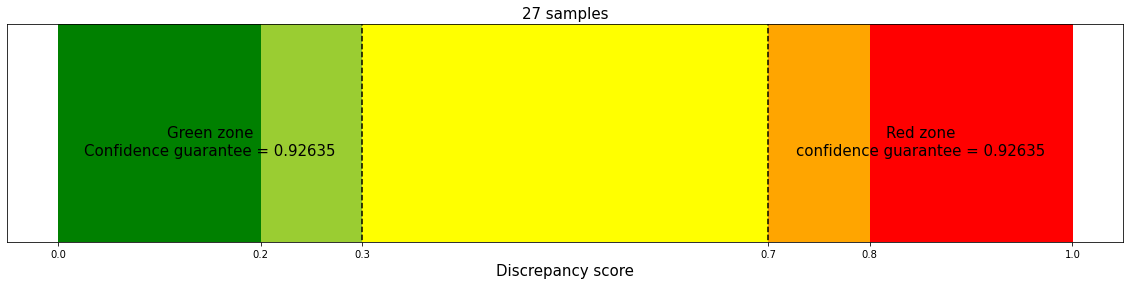

In [5]:
a = 0.1
t_green = 0.3
t_red = 0.7
confidence = 0.9

n_samples = binomial_confidence.get_n_samples(accuracy = a, t_green = t_green, t_red = t_red, confidence = confidence, make_plot = True)

## Vary parameters and see effects on n_samples

t_green = 0.1
     t_red = 0.1
     t_red = 0.3
     t_red = 0.5
t_green = 0.3
     t_red = 0.1
     t_red = 0.3
     t_red = 0.5
t_green = 0.5
     t_red = 0.1
     t_red = 0.3
     t_red = 0.5


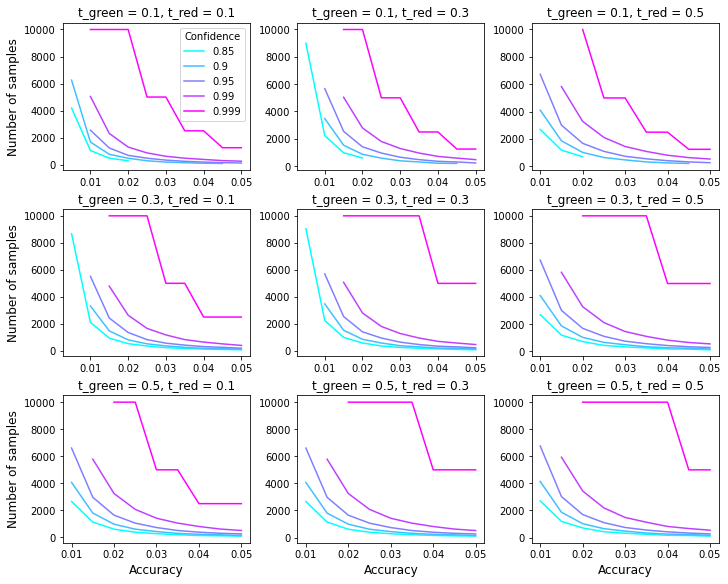

In [54]:
fig, ax = plt.subplots(nrows = 3, ncols = 3, constrained_layout = True, figsize = [10, 8])

accuracy_range = np.linspace(0.005, 0.05, 10)
confidence_range = [0.85, 0.9, 0.95, 0.99, 0.999]
confidence_colours = plt.cm.cool(np.linspace(0, 1, 5))
t_green_range = [0.1, 0.3, 0.5]
t_red_range = [0.1, 0.3, 0.5]

row = 0
col = 0

for t_green in t_green_range:
    print('t_green = {0}'.format(t_green))
    col = 0
    for t_red in t_red_range:
        print('     t_red = {0}'.format(t_red))
        ax[row, col].set_title('t_green = {0}, t_red = {1}'.format(t_green, t_red))
        
        i = 0
        for confidence in confidence_range:
            #print('           Confidence = {0}'.format(confidence))
            n_samples = [binomial_confidence.get_n_samples(accuracy = a, t_green = t_green, t_red = t_red, confidence = confidence, suppress_warnings = True) for a in accuracy_range]
            ax[row, col].plot(accuracy_range, n_samples, color = confidence_colours[i], label = confidence)
            i += 1
                
        if col == 0:
            ax[row, col].set_ylabel('Number of samples', fontsize = 12)
            if row == 0:
                ax[row, col].legend(title = 'Confidence')
        if row == 2:
            ax[row, col].set_xlabel('Accuracy', fontsize = 12)
        col += 1
    row += 1

## Schematic

Text(0.5, 1.0, '842 samples')

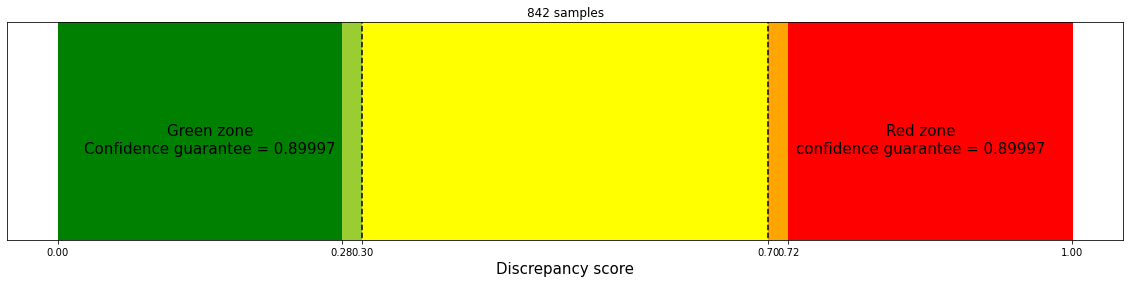

In [113]:
t_green = 0.3
t_red = 0.7
accuracy = 0.02
confidence = 0.9
p_green = p_high_green
p_red = p_high_red
n_samples = n_high

fig, ax = plt.subplots(figsize = [20, 4])

width = 1
box_bottom = 1
height = 0.1*width

# Green zone - confidence guarantee
left = 0
right = t_green - accuracy
rect = Rectangle([left, box_bottom], right - left, height, color = 'g')
ax.add_patch(rect)
#plt.plot([left, right], [1, 1], linewidth = 10, color = 'g')

# Green zone - out of confidence guarantee
left = t_green - accuracy
right = t_green
rect = Rectangle([left, box_bottom], right - left, height, color = 'yellowgreen')
ax.add_patch(rect)
#plt.plot([left, right], [1, 1], linewidth = 10, color = 'yellowgreen')

# Yellow zone
left = t_green
right = t_red
rect = Rectangle([left, box_bottom], right - left, height, color = 'yellow')
ax.add_patch(rect)
#plt.plot([left, right], [1, 1], linewidth = 10, color = 'g')

# Red zone - out of confidence guarantee
left = t_red 
right = t_red + accuracy
rect = Rectangle([left, box_bottom], right - left, height, color = 'orange')
ax.add_patch(rect)

# Red zone - confidence guarantee
left = t_red + accuracy
right = 1
rect = Rectangle([left, box_bottom], right - left, height, color = 'r')
ax.add_patch(rect)

plt.plot([t_green, t_green], [box_bottom - 0.1*height, box_bottom + 1.1*height], color = 'k', linestyle = '--')
plt.plot([t_red, t_red], [box_bottom - 0.1*height, box_bottom + 1.1*height], color = 'k', linestyle = '--')
plt.yticks([])
plt.xticks(np.round([0, t_green - accuracy, t_green, t_red, t_red + accuracy, 1], 2))
plt.xlabel('Discrepancy score', fontsize = 15)
plt.text(t_green/2, 1.04, 'Green zone\nConfidence guarantee = {0}'.format(np.round(p_green, 5)), fontsize = 15, horizontalalignment = 'center')
plt.text((1 + t_red)/2, 1.04, 'Red zone\nconfidence guarantee = {0}'.format(np.round(p_red, 5)), fontsize = 15, horizontalalignment = 'center')
plt.ylim([box_bottom, box_bottom + height])

plt.title('{0} samples'.format(n_samples))

#plt.show()